In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

In [2]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.interpolate import griddata

from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_spd_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [3]:
# Sorts an array by it's columns
def sort_by_col(x):
    return x[np.argsort(x[:,0])]

# Overview of Kmeans++

First is just data checking, if it's a DataFrame, convert it to a NumPy array
Then we randomly select our first centroid using np.random.randint in the range of 0..n
Now we loop for each other centroid
- We calculate the minimum distances from every point to every centroid, and only use the minimums
- Then we take the largest distance from the previous step, and select that as our next centroid
Convert the centroids to an array and return

In [4]:
def kmeanspp(points,n):
    """
        points: data points to generate centroids from
        n     : number of centroids to generate
    """
    # if it's a dataframe, convert to numpy array
    if isinstance(points,pd.DataFrame):
        points = points.to_numpy()

    # Select our first point
    centroids = [points[np.random.randint(points.shape[0])]]
    
    # For every other new centroid
    for _ in range(n - 1):
        # Create a list of the minimum distances from each point to each centroid
        # Each entry is per point, meaning it's the minimum distance from this point to the closest centroid
        dists = [np.min([np.linalg.norm(points[i] - centroids[j]) for j in range(len(centroids))]) for i in range(points.shape[0])]
        # Add the point with the largest distance
        centroids.append(points[np.argmax(dists)])
    return np.array(centroids)

# Overview of Expectation Maximization (EM)
The first section is just data checking as well as parameter checking
- Check if the points are a DataFrame and convert to NumPy array
- Then check if init_cen was passed, if it wasn't, generate centroids using Kmeans++. Otherwise shape checking
- Then check if init_cov was passed, if it wasn't generate them as identity matrices. Otherwise shape checking
- Then check if init_probs was passed, if it wasn't genereate it as uniform distribution. Otherwise shape checking and distribution checking

Then a quick copy to make sure we don't alter any mutable arguments passed in

Then the loop is defined per iteration
- There are comments in the code to say what each step is doing. They are created from the formulas provided below:

\begin{align}
\huge
    r_{ik} = \frac{\pi_k\mathcal{N}(x_i|\theta_k^{t-1})}{\sum_{\grave{k}}\pi_{\grave{k}}\mathcal{N}(x_i|\theta_{\grave{k}}^{t-1})}
\end{align}

Each iteration:
- Perform an E step
- Perform an M step
- From the E step, take the log likelihoods and sum them
- Compare the log likelihood from this iteration and check vs the previous
    - If the distance between the current and last log likelihood is less than the tolerance, we can return now since we converged
    - Otherwise, continue the iteration

In [5]:
def expectation_maximization(points,n,maxiter=100,tol=1e-4,init_cen=None,init_cov=None,init_probs=None):
    """
        points     : data points to generate clusters from
        n          : number of clusters to generate
        maxiter    : maximum number of iterations to run algorithm (may converge before reaching)
        tol        : the tolerance for convergence
        init_cen   : the initial centroids. If None, kmeans++ will be used to generate them
        init_cov   : the initial covariance matrix for each centroid (must be of shape (n,d,d) where d is the dimensionality of the data (2 for 2D, 3 for 3D, etc)). If None, will be initialized to identity matrices for each
        init_probs : the initial probabilty distribution for the points (must be of shape (n,) or (n,1)). If None, will be initialized to uniform distribution
    """
    if isinstance(points,pd.DataFrame):
        points = points.to_numpy()

    # If there's no initial centroids, generate them
    if init_cen is None:
        init_cen = kmeanspp(points,n)
    # If there are centroids, make sure the shapes match
    else:
        assert n == init_cen.shape[0], "Shape of initial centroids must be the same as the number of clusters"
        
    # If no initial covariance is supplied, create using identity matrices
    if init_cov is None:
        init_cov = np.array([np.identity(points.shape[1]) for _ in range(n)])
    else:
        assert init_cov.shape == (n,2,2), "Shape of initial covariances must be (n,d,d) where n is the number of clusters and d is the dimensionaly of the data"

    # If no initial cluster probability distribution is supplied, use uniform
    if init_probs is None:
        init_probs = np.ones(n) / n
    else:
        assert init_probs.shape == (n,) or init_probs.shape == (n,1) , "Shape of initial probabilities must be (n,) or (n,1)"
        assert np.sum(init_probs) == 1, "Initial probabilities must sum to 1"
        assert np.all(init_probs <= 1) and np.all(init_probs >= 0), "Each value in init_probs must be in [0,1]"
        
    # Setup the parameters, copying to insure no changes to mutable data
    means = init_cen.copy()
    cov = init_cov.copy()
    pi = init_probs.copy()
    
    prev_likelihood = 0
    all_likelihoods = []
    for it in range(maxiter):
        # E step
        # calculate the likelihood of each point the current mean/covariance
        likelihood = np.array([stats.multivariate_normal.pdf(points,means[j],cov[j]) for j in range(n)])
        
        # M step
        denom = np.sum([likelihood[i] * pi[i] for i in range(n)],axis=0)
        for j in range(n):
            # r is the likelihood divided by the sum of the likelihoods
            r = ((likelihood[j] * pi[j]) / denom).reshape(-1,1)
            
            # Bottom is the sum of all r
            bot = np.sum(r)
            # Mu k
            means[j] = np.sum(r * points,axis=0) / bot
            
            # Difference between points and mean vectors
            diffs = points - means[j]
            # Sigma k
            cov[j] = ((r * diffs).T @ diffs) / bot
            
            # Pi k
            pi[j] = np.mean(r)
            
        # Check log-likelihood between iterations
        curr_likelihood = np.sum(np.log(np.sum(likelihood,axis=1)))
        all_likelihoods.append(curr_likelihood)

        # If there is convergence, break
        if np.abs(curr_likelihood - prev_likelihood) <= tol:
            return means, cov, pi, all_likelihoods, it + 1
        # Otherwise continue
        else:
            prev_likelihood = curr_likelihood
    return means, cov, pi, all_likelihoods, maxiter

def predict(points,means,cov,pi):
    """
        points : the points to predict centroids from
        means  : the centroids to classift points to
        cov    : the covariance matrix after clustering
        pi     : the probability distribution after clustering
    """
    if isinstance(points,pd.DataFrame):
        points = points.to_numpy()

    # calculate the likelihood for each point to each distribution
    likelihood = np.array([stats.multivariate_normal.pdf(points,means[j],cov[j]) for j in range(means.shape[0])])
    # calculate the denom for calculating r
    denom = np.sum([likelihood[i] * pi[i] for i in range(means.shape[0])],axis=0)
    # calculate the r for each point
    # shape is (n_clusters, n_points, 1)
    rs = np.array([((likelihood[j] * pi[j]) / denom).reshape(-1,1) for j in range(means.shape[0])])

    # Take the maximum of each point to the mean, flatten to 1d array
    return np.argmax(rs,axis=0).flatten()

In [6]:
# These plotting functions were taken from StackOverflow since the implementation was solid
# https://stackoverflow.com/questions/26999145/matplotlib-making-2d-gaussian-contours-with-transparent-outermost-layer
def gauss(x,y,Sigma,mu):
    X=np.vstack((x,y)).T
    mat_multi=np.dot((X-mu[None,...]).dot(np.linalg.inv(Sigma)),(X-mu[None,...]).T)
    return  np.diag(np.exp(-1*(mat_multi)))

def plot_contour(x,y,zs,ls):
    fig = plt.figure(figsize=(10,10))
    # define grid.
    xi = np.linspace(0,1.5,100)
    yi = np.linspace(0,1.1,100)
    ## grid the data.
    z_s = [griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic') for z in zs]
    levels = [.2,.4,.6,.8,1]
    
    plt.scatter(x, y, c=ls)
    
    for i in range(len(zs)):
        # contour the gridded data, plotting dots at the randomly spaced data points.
        CS = plt.contour(xi,yi,z_s[i],len(levels),linewidths=1,colors='k', levels=levels)
    # plot data points.
    plt.xlim(0, 1.5)
    plt.ylim(0, 1.1)
    plt.show()

In [7]:
# Take a peek at the data
data = pd.read_excel("./GMM-Data.xlsx")
data

,x1,x2,class
0,0.813635,0.034228,1
1,0.628865,0.056311,1
2,0.620791,0.059511,1
3,0.686144,0.077669,1
4,0.823733,0.098199,1
...,...,...,...
495,0.751288,0.934229,2
496,0.723617,0.936894,2
497,0.397034,0.938962,3
498,0.396907,0.948221,3


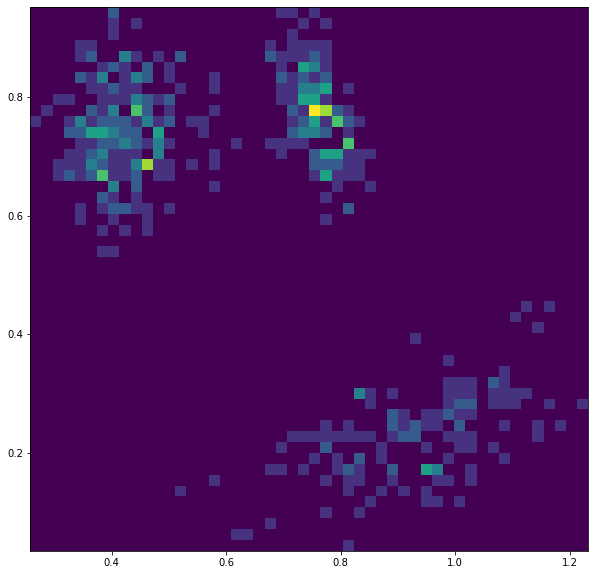

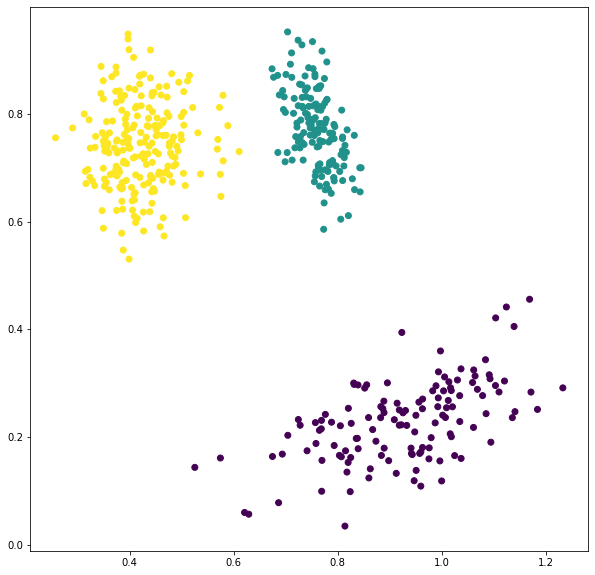

In [8]:
# Draw a 2D histogram of the data with 50 bins
fig = plt.figure(figsize=(10,10))
plt.hist2d(data["x1"],data["x2"],50)
plt.show()

# Plot the data with it's correct classes
fig = plt.figure(figsize=(10,10))
plt.scatter(data["x1"],data["x2"],c=data["class"])
plt.show()

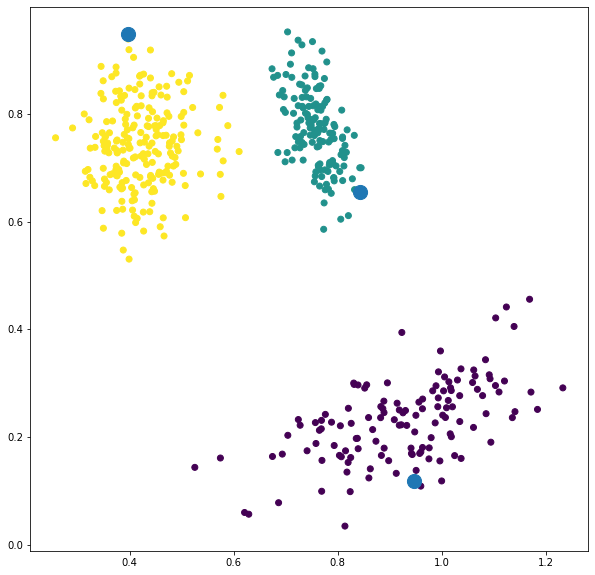

In [9]:
np.random.seed(100) # See the random for reproducibility
c = kmeanspp(data[["x1","x2"]],3)
c = sort_by_col(c) # Sort this so that we can compare them later

# Plot the data with correct classes
# Plot the centroids generated from Kmeans++
fig = plt.figure(figsize=(10,10))
plt.scatter(data["x1"],data["x2"],c=data["class"])
plt.scatter(c[:,0],c[:,1],s=200)
plt.show()

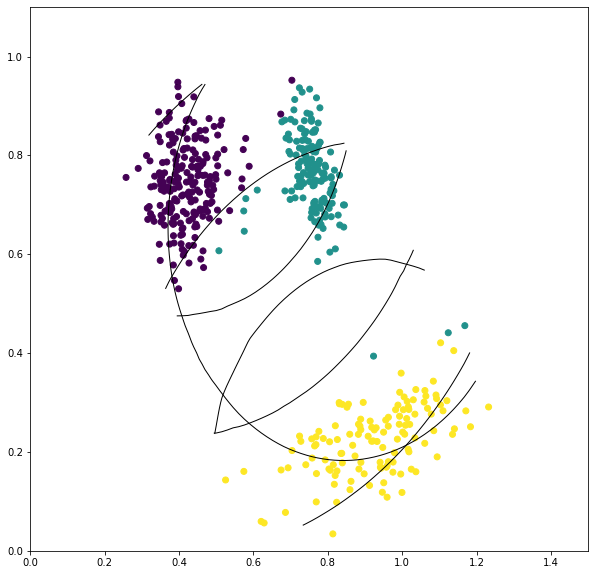

In [10]:
# Run EM algorithm 0 times (generates first means/cov/pi)
m,cov,pi,ls,its = expectation_maximization(data[["x1","x2"]],3,maxiter=0,init_cen=c)
# Predict each point
labs = predict(data[["x1","x2"]],m,cov,pi)

# Convert everything, compute gaussians for each cov/m
x = data["x1"].to_numpy()
y = data["x2"].to_numpy()
z1 = gauss(x,y,cov[0],m[0])
z2 = gauss(x,y,cov[1],m[1])
z3 = gauss(x,y,cov[2],m[2])
zz = [z1,z2,z3]

# Plot the contout plot
plot_contour(x,y,zz,labs)

# We can see that the Gaussian Components get somewhat skewed
# They're currently larger than the plot function handles, so it looks very messy

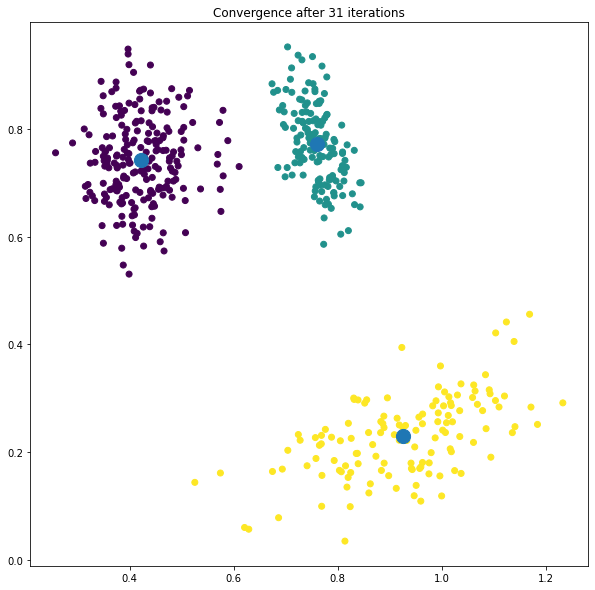

In [11]:
# Run the EM algorithm a max of 100 times (may end faster)
m,cov,pi,ls,its = expectation_maximization(data[["x1","x2"]],3,maxiter=100,init_cen=c)
# Predict the classes for each point
labs = predict(data[["x1","x2"]],m,cov,pi)

# Plot the points with their predictions
fig = plt.figure(figsize=(10,10))
plt.title(f"Convergence after {its} iterations")
plt.scatter(data["x1"],data["x2"],c=labs)
plt.scatter(m[:,0],m[:,1],s=200)
plt.show()

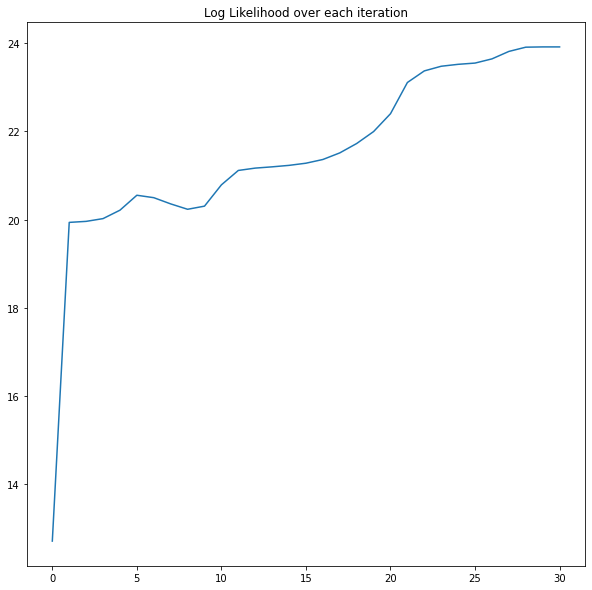

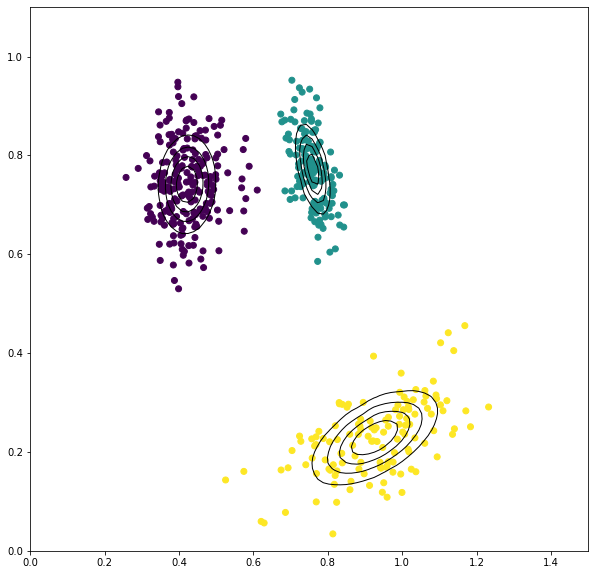

In [12]:
# Plot how the log likelihoods change over time
fig = plt.figure(figsize=(10,10))
plt.title("Log Likelihood over each iteration")
plt.plot(ls)
plt.show()

# Convert everything, compute gaussians for each cov/m
x = data["x1"].to_numpy()
y = data["x2"].to_numpy()
z1 = gauss(x,y,cov[0],m[0])
z2 = gauss(x,y,cov[1],m[1])
z3 = gauss(x,y,cov[2],m[2])
zz = [z1,z2,z3]

# Plot the contour
plot_contour(x,y,zz,labs)

# We can see that the log likelihoods eventually don't change more than the tol
# Also we can see there was only 31 iterations

# When inspecting the Gaussian components, it looks pretty good

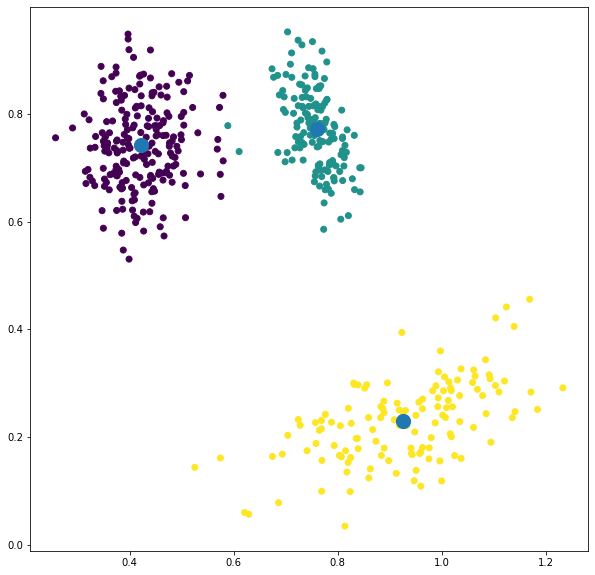

2


In [13]:
# Create a KMeans obj with 3 clusters and init with our kmeans++
km = KMeans(n_clusters=3,init=c,max_iter=100,n_init=1)

# Fit and predict the clusters/labels
label = km.fit_predict(data[["x1","x2"]])

# Plot the results
fig = plt.figure(figsize=(10,10))
plt.scatter(data["x1"],data["x2"],c=label)
plt.scatter(m[:,0],m[:,1],s=200)
plt.show()

# number of points that don't compare
print(np.sum(label != labs))

# It seems that KMeans for this dataset using Euclidean Distance (L2 norm) doesn't work as well as EM

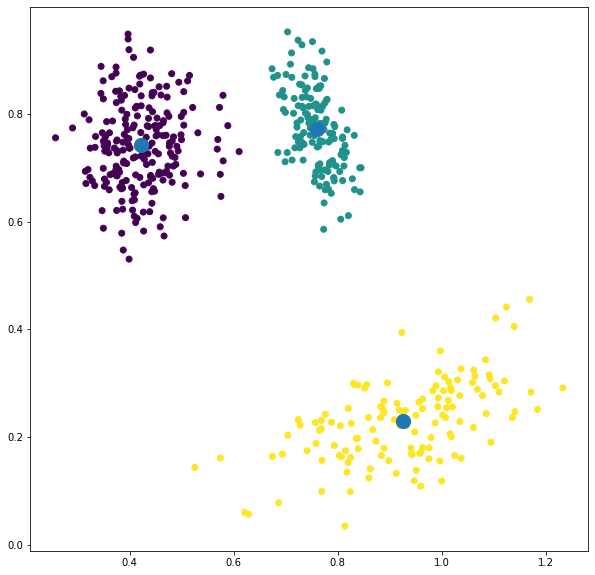

0

[[[ 0.0036674   0.00025332]
  [ 0.00025332  0.00620774]]

 [[ 0.00130178 -0.00135753]
  [-0.00135753  0.00520617]]

 [[ 0.01774289  0.00567881]
  [ 0.00567881  0.00563869]]]
[[[ 0.0036664   0.00025332]
  [ 0.00025332  0.00620674]]

 [[ 0.00130078 -0.00135753]
  [-0.00135753  0.00520517]]

 [[ 0.01774189  0.00567881]
  [ 0.00567881  0.00563769]]]

[0.43601105 0.30198899 0.26199996]
[0.43601106 0.30198898 0.26199996]

[[0.4215486  0.74144431]
 [0.75965166 0.77212741]
 [0.92612491 0.22870629]]
[[0.42154861 0.7414443 ]
 [0.75965167 0.77212741]
 [0.92612491 0.22870629]]


In [14]:
# Use ScitKit-Learn's GuassianMixture Model, init with our kmeans++
gm = GaussianMixture(n_components=3,max_iter=100,tol=1e-4,means_init=c)

# Compute labels and fit the data
label = gm.fit_predict(data[["x1","x2"]])

# Plot the points, the labels, and the centroids
fig = plt.figure(figsize=(10,10))
plt.scatter(data["x1"],data["x2"],c=label)
plt.scatter(m[:,0],m[:,1],s=200)
plt.show()

# number of points that don't compare
print(np.sum(label != labs))
print()
# Visually inspect the covariances between sklearn and my implementation
print(gm.covariances_)
print(cov)
print()
# Visually inspect the probability distribution
print(gm.weights_)
print(pi)
print()
# Visually inspect the means
print(gm.means_)
print(m)

# We can see that the GaussianMixture implementation and my implementation are very close to the same

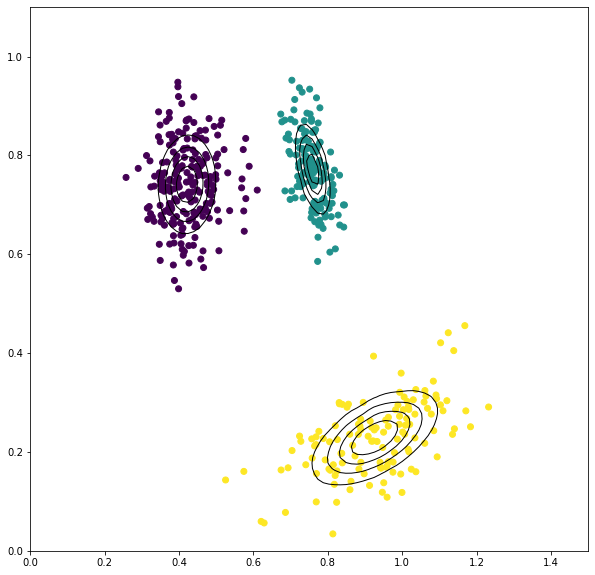

In [15]:
# Plot the contours from GaussianMixture
x = data["x1"].to_numpy()
y = data["x2"].to_numpy()
z1 = gauss(x,y,gm.covariances_[0],gm.means_[0])
z2 = gauss(x,y,gm.covariances_[1],gm.means_[1])
z3 = gauss(x,y,gm.covariances_[2],gm.means_[2])
zz = [z1,z2,z3]

plot_contour(x,y,zz,labs)

C:\Users\bvano\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


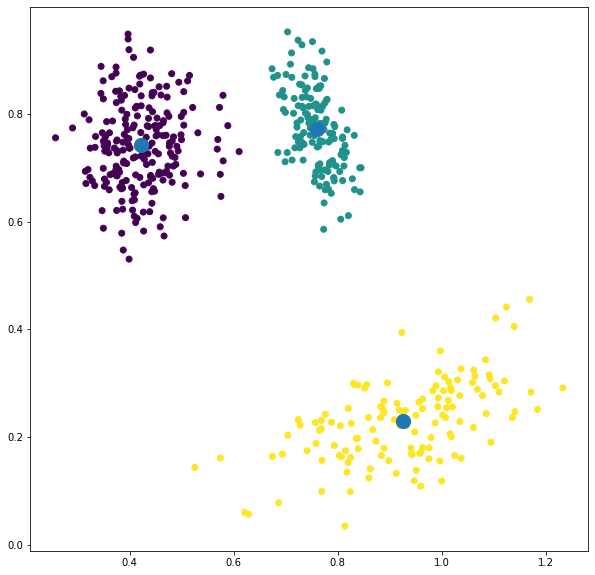

0

[[[ 0.0036674   0.00025332]
  [ 0.00025332  0.00620774]]

 [[ 0.00130178 -0.00135753]
  [-0.00135753  0.00520617]]

 [[ 0.01774289  0.00567881]
  [ 0.00567881  0.00563869]]]
[[[ 0.0036664   0.00025332]
  [ 0.00025332  0.00620674]]

 [[ 0.00130078 -0.00135753]
  [-0.00135753  0.00520517]]

 [[ 0.01774189  0.00567881]
  [ 0.00567881  0.00563769]]]

[0.43601105 0.30198899 0.26199996]
[0.43601106 0.30198898 0.26199996]
[[0.4215486  0.74144431]
 [0.75965166 0.77212741]
 [0.92612491 0.22870629]]
[[0.42154861 0.7414443 ]
 [0.75965167 0.77212741]
 [0.92612491 0.22870629]]


In [16]:
# Create a GuassianMixture sklearn obj, init with their own init
# Only init once to just take the means from
gm = GaussianMixture(n_components=3,max_iter=1,tol=1e-4)

# Fit the data to compute the means
gm.fit(data[["x1","x2"]])
# Take the means and sort them
temp = sort_by_col(gm.means_)

# Recreate the model using the new means (just sorted)
gm = GaussianMixture(n_components=3,max_iter=100,tol=1e-4,means_init=temp) # reset the model using the previously generated means; allows us to compare labels properly
label = gm.fit_predict(data[["x1","x2"]])

# Plot the model
fig = plt.figure(figsize=(10,10))
plt.scatter(data["x1"],data["x2"],c=label)
plt.scatter(m[:,0],m[:,1],s=200)
plt.show()

print(np.sum(label != labs)) # number of points that don't compare
print()
print(gm.covariances_)
print(cov)
print()
print(gm.weights_)
print(pi)
# Visually inspect the means
print(gm.means_)
print(m)

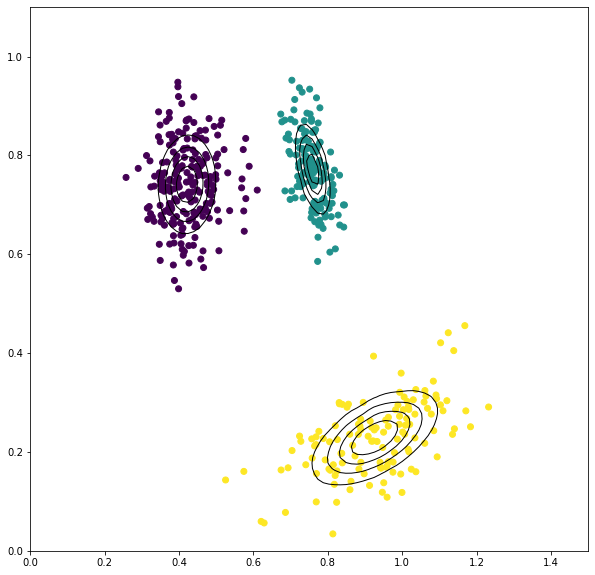

In [17]:
# Plot the contours
x = data["x1"].to_numpy()
y = data["x2"].to_numpy()
z1 = gauss(x,y,gm.covariances_[0],gm.means_[0])
z2 = gauss(x,y,gm.covariances_[1],gm.means_[1])
z3 = gauss(x,y,gm.covariances_[2],gm.means_[2])
zz = [z1,z2,z3]

plot_contour(x,y,zz,labs)

# Overall it seems that my implementation worked pretty well
# When it comes to comparing to original classes to the calculated classes, it compares perfectly
# Each point is correclty classified to the cluster in belongs to

# However, KMeans struggles to cluster this data correctly because of the shape of the clusters